In [8]:
!pip install mtcnn

In [9]:
%pip install torch torchvision Pillow facenet_pytorch

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
from PIL import Image, ImageDraw
from facenet_pytorch import MTCNN
import matplotlib.pyplot as plt

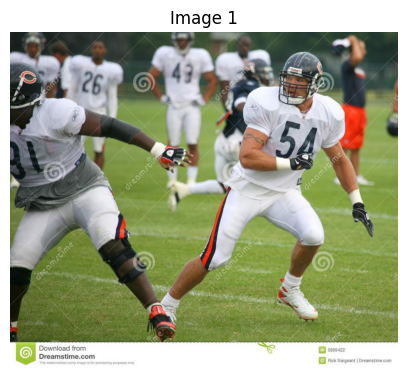

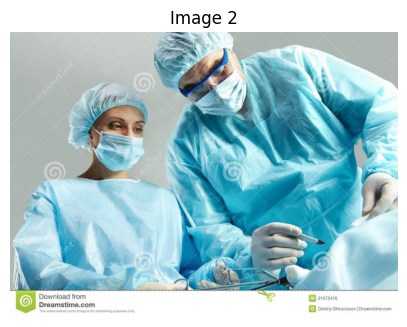

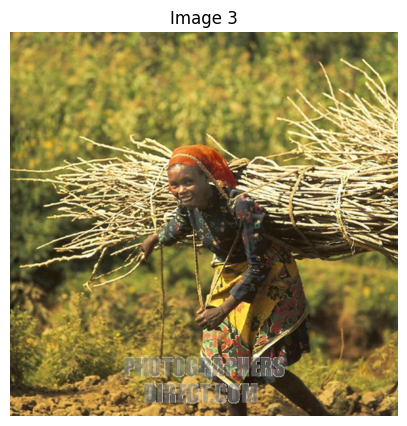

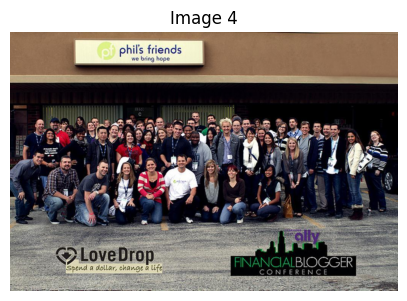

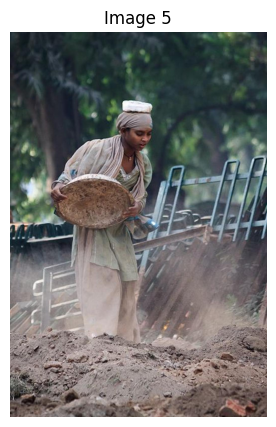

In [20]:

# List of image paths
image_paths = [
    "/kaggle/input/face-detection-dataset/merged/images/validation/1765.jpeg",
    "/kaggle/input/face-detection-dataset/merged/images/validation/1436.jpeg",
    "/kaggle/input/face-detection-dataset/merged/images/validation/1528.jpeg",
    "/kaggle/input/face-detection-dataset/merged/images/validation/266.jpeg",
    "/kaggle/input/face-detection-dataset/merged/images/validation/1543.jpeg"
]

# Define the output folder path
output_folder = "/kaggle/working/output_images"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through the image paths and plot each image one by one
for idx, image_path in enumerate(image_paths):
    if os.path.exists(image_path): 
        image = Image.open(image_path) 
        
        # Create a new figure for each image
        plt.figure(figsize=(5, 5))
        plt.imshow(image)  
        plt.title(f"Image {idx + 1}")  
        plt.axis("off")  
        plt.show()  
        
        # Save the image to the output folder
        output_image_path = os.path.join(output_folder, f"image_{idx + 1}.png")
        image.save(output_image_path)
        
    else:
        print(f"Image not found: {image_path}") 


Detected boxes for 1765.jpeg: [[726.116455078125 108.45957946777344 786.039794921875 179.41973876953125]
 [216.65696716308594 29.311542510986328 249.01695251464844
  72.26045989990234]
 [48.63313293457031 30.145776748657227 74.7722396850586 62.83368682861328]]
Ground truth boxes for 1765.jpeg: [(-83.89674523007857, 630.8349609375, 83.89674523007857, 690.873046875), (-31.892255892255893, 188.8154296875, 31.892255892255893, 217.529296875), (-24.134680134680135, 523.810546875, 24.134680134680135, 552.5244140625), (-19.250280583613918, 380.2412109375, 19.250280583613918, 416.7861328125), (-27.58249158249158, 37.4150390625, 27.58249158249158, 70.4794921875), (-31.604938271604937, 795.287109375, 31.604938271604937, 817.91015625)]
Detected boxes for 1436.jpeg: [[448.95458984375 36.7988166809082 640.3262939453125 238.27967834472656]
 [227.46409606933594 196.25941467285156 365.3974914550781
  367.686767578125]]
Ground truth boxes for 1436.jpeg: [(-183.342175066313, 166.41015625, 183.34217506631

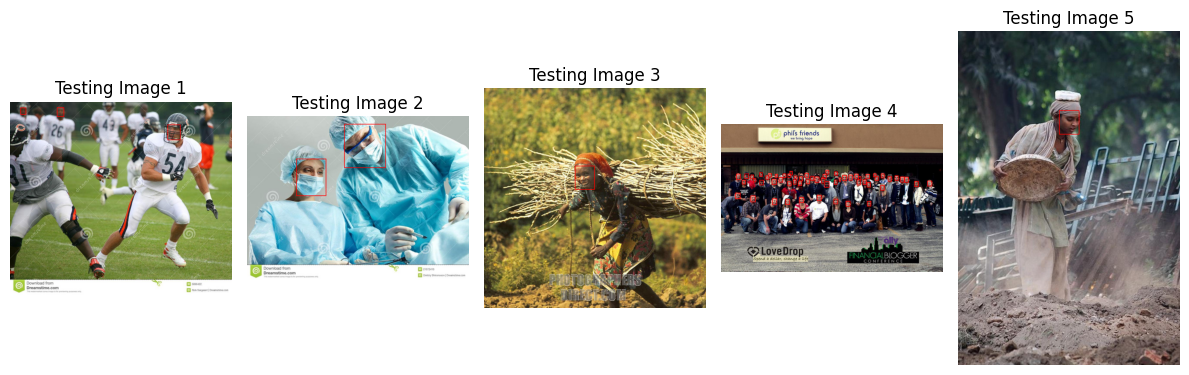

Mean IoU: 0.007939509197251175


In [5]:
# Function to calculate IoU
def calculate_iou(box1, box2):
    # Calculate intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate union
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * max(0, box2[3] - box2[1])
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

# Set the paths to the validation images and labels
val_images_path = '/kaggle/input/face-detection-dataset/merged/images/validation'
val_labels_path = '/kaggle/input/face-detection-dataset/merged/labels/validation'

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=True)

# Function to convert relative to absolute bounding boxes
def relative_to_absolute(bbox, img_width, img_height):
    if len(bbox) < 4:
        return None  # Handle cases where there are not enough values
    center_x, center_y, width, height = bbox[:4]  # Extract four values
    abs_x1 = (center_x - width / 2) * img_width
    abs_y1 = (center_y - height / 2) * img_height
    abs_x2 = (center_x + width / 2) * img_width
    abs_y2 = (center_y + height / 2) * img_height
    return (abs_x1, abs_y1, abs_x2, abs_y2)

# Function to detect and draw faces
def detect_and_draw_faces(img_path, ground_truth_boxes):
    try:
        img = Image.open(img_path).convert('RGB')
        img_width, img_height = img.size
        
        # Convert ground truth boxes from relative to absolute coordinates
        absolute_boxes = [
            relative_to_absolute(box, img_width, img_height) for box in ground_truth_boxes
        ]

        # Filter out any None values
        absolute_boxes = [box for box in absolute_boxes if box]

        boxes, _ = mtcnn.detect(img)

        if boxes is not None:
            img_draw = img.copy()
            draw = ImageDraw.Draw(img_draw)
            for box in boxes:
                draw.rectangle(box.tolist(), outline="red", width=3)

            # Calculate IoU for each detected box
            ious = []
            for box in boxes:
                best_iou = 0
                for gt_box in absolute_boxes:
                    iou = calculate_iou(box, gt_box)
                    best_iou = max(best_iou, iou)
                ious.append(best_iou)

            # Log the detected and ground truth bounding boxes
            print(f"Detected boxes for {os.path.basename(img_path)}: {boxes}")
            print(f"Ground truth boxes for {os.path.basename(img_path)}: {absolute_boxes}")

            return img_draw, ious
        else:
            print(f"No faces detected in {os.path.basename(img_path)}")
            return None, []

    except Exception as e:
        print(f"Error processing {os.path.basename(img_path)}: {e}")
        return None, []

# Get the first five images from the validation folder
image_files = [f for f in os.listdir(val_images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
num_images_to_process = min(5, len(image_files))  # Limit to five images

plt.figure(figsize=(12, 8))
total_ious = []

for idx, img_name in enumerate(image_files[:num_images_to_process]):
    img_path = os.path.join(val_images_path, img_name)

    # Create label file path
    label_path = os.path.join(val_labels_path, img_name.split('.')[0] + '.txt')

    if not os.path.exists(label_path):
        print(f"Label file not found for {img_name}")
        continue  # Skip this image if no label found

    # Read ground truth bounding boxes
    with open(label_path, 'r') as f:
        try:
            ground_truth_boxes = [tuple(map(float, line.strip().split())) for line in f]
        except ValueError:
            print(f"Error reading label data for {img_name}")
            continue  # Skip this image if label data is incorrect

    img_with_boxes, ious = detect_and_draw_faces(img_path, ground_truth_boxes)
    total_ious.extend(ious)

    if img_with_boxes:
        plt.subplot(1, 5, idx + 1)
        plt.title(f"Testing Image {idx + 1}")
        plt.imshow(img_with_boxes)
        plt.axis("off")

plt.tight_layout()
plt.show()

# Calculate the mean IoU
mean_iou = sum(total_ious) / len(total_ious) if total_ious else 0
print(f"Mean IoU: {mean_iou}")
